# Notebook #3: Modeling (Prep, Modeling, & Results)
Capstone Project\
ADS-599 Summer 2024\
Roger Qiu & Shailja Somani

This notebook begins with the clean, consolidated, & encoded dataset that results from the the notebook *1_Data_Preparation.ipynb*. Please run through that notebook prior to this one to obtain *prepped_dataset.csv*. We are unfortunately unable to upload that consolidated dataset to Github due to the file being too large. 

## Table of Contents
1. [Setup and Package Imports](#setup-and-package-imports)
2. [Load in Data](#load-in-data)
3. [Data Pre-Processing for Modeling](#data-pre-processing-for-modeling)
    1. [Modeling Approach #1](#modeling-approach-1)
        1. [Handle Null Values](#handle-null-values-1)
        2. [Train-Test Split and Scale X Features](#train-test-split-and-scale-x-features)
    2. [Modeling Approach #2](#modeling-approach-2)
        1. [Handle Null Values](#handle-null-values-2)
        2. [Scaling Prior to PCA](#scaling-prior-to-pca)
        3. [KNN Imputation for Remaining Nulls](#knn-imputation-for-remaining-nulls)
        4. [PCA on Just SDOH Features](#pca-on-just-sdoh-features)
        5. [Apply fitted transformers (KNNImputer, PCA & Scaling) to test features](#apply-fitted-transformers-knnimputer-pca--scaling-to-test-features)
    3. [Save pre-processed datasets as checkpoint prior to beginning modeling](#save-pre-processed-datasets-as-checkpoint-prior-to-beginning-modeling)
    4. [Split into X and y and Train-Test Split](#split-into-x-and-y-and-train-test-split)
4. [Modeling](#modeling)
    1. [Modeling Approach #1: Limited SDOH Columns](#modeling-approach-1-limited-sdoh-columns)
        1. [Identifying Optimal Model for Approach #1](#identifying-optimal-model-for-approach-1)
        2. [Approach #1 Final Model](#approach-1-final-model)
    2. [Modeling Approach #2: PCA on SDOH Columns](#modeling-approach-2-pca-on-sdoh-columns)
        1. [Identifying Optimal Model for Approach #2](#identifying-optimal-model-for-approach-2)
        2. [Approach #2 Final Model](#approach-2-final-model)
5. [Final Model (LGBMRegressor): SHAP Values](#final-model-lgbmregressor-shap-values)


## Setup & Package Imports

In [9]:
# import numpy & pandas to handle data
import pandas as pd
import numpy as np

# import matplotlib for graphs and visualizations
import matplotlib.pyplot as plt

# import seaborn for Multivariate Graphical Analysis
import seaborn as sns

# Sklearn imports for pre-processing
from sklearn.preprocessing import StandardScaler # For scaling features
from sklearn.impute import KNNImputer # For imputing null features
from sklearn.decomposition import PCA # For dimensionality reduction
from sklearn.model_selection import train_test_split # For train-test split

# Sklearn imports for modeling, hyperparmeters & evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# For additional model explainability
import shap

In [10]:
# Ignore warnings to make output print nicer
import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [2]:
# read in the cleaned and consolidated dataset for EDA
full_data = pd.read_csv('/Users/shailjasomani/Documents/USD_MS_ADS/ADS_599/Datasets/prepped_dataset.csv')
full_data.head()

,location_name,TARGET_mortality_rate,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,...,Sleep <7 hours,Stroke,Taking BP Medication,Vision Disability,race__API,race__Black,race__Latino,race__White,sex__Male,age_category
0,Autauga County (Alabama),0.0,55380.0,54699.0,52163.0,44749.0,43953.0,3016.0,37367.0,41725.0,...,40.040,3.680,79.660000,6.320000,0,0,1,0,0,0
1,Autauga County (Alabama),0.0,55380.0,54699.0,52163.0,44749.0,43953.0,3016.0,37367.0,41725.0,...,40.040,3.680,79.660000,6.320000,0,1,0,0,0,0
2,Autauga County (Alabama),0.0,55380.0,54699.0,52163.0,44749.0,43953.0,3016.0,37367.0,41725.0,...,40.040,3.680,79.660000,6.320000,0,0,0,1,0,0
3,Baldwin County (Alabama),0.0,212830.0,210908.0,201141.0,174821.0,172297.0,10307.0,151112.0,166417.0,...,34.975,3.625,81.445833,5.104167,0,0,1,0,0,0
4,Baldwin County (Alabama),0.0,212830.0,210908.0,201141.0,174821.0,172297.0,10307.0,151112.0,166417.0,...,34.975,3.625,81.445833,5.104167,0,1,0,0,0,0


In [5]:
full_data['TARGET_mortality_rate'].mean()

9.633472092085713e-05

In [70]:
# Drop location_name column as it's not relevant to modeling
full_data.drop(columns=['location_name'], inplace=True)

# Fix column names so no issues later on in XGBoost
# Function to clean column names
def clean_column_names(columns):
    cleaned_columns = []
    for col in columns:
        col = col.replace('[', '_').replace(']', '_').replace('<', '_')
        cleaned_columns.append(col)
    return cleaned_columns

# Apply the cleaning function to column names
full_data.columns = clean_column_names(full_data.columns)

# Preview
full_data.head()

,TARGET_mortality_rate,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,ACS_TOT_WORKER_NWFH,ACS_TOT_WORKER_HH,ACS_TOT_CIVILIAN_LABOR,ACS_TOT_CIVIL_EMPLOY_POP,ACS_TOT_POP_POV,ACS_TOT_CIVIL_NONINST_POP_POV,ACS_TOT_CIVIL_POP_POV,ACS_TOT_GRANDCHILDREN_GP,ACS_TOT_HU,ACS_TOT_HH,ACS_AVG_HH_SIZE,ACS_TOT_CIVIL_NONINST_POP,ACS_TOT_CIVIL_VET_POP,ACS_PCT_CHILD_DISAB,ACS_PCT_DISABLE,ACS_PCT_NONVET_DISABLE_18_64,ACS_PCT_VET_DISABLE_18_64,ACS_PCT_MALE,ACS_PCT_FEMALE,ACS_PCT_CTZ_US_BORN,ACS_PCT_CTZ_NONUS_BORN,ACS_PCT_FOREIGN_BORN,ACS_PCT_NON_CITIZEN,ACS_PCT_CTZ_NATURALIZED,ACS_PCT_CTZ_ABOVE18,ACS_PCT_NONCTN_1990,ACS_PCT_NONCTN_1999,ACS_PCT_NONCTN_2000,ACS_PCT_NONCTN_2010,ACS_PCT_API_LANG,ACS_PCT_ENGL_NOT_ALL,ACS_PCT_ENGL_NOT_WELL,ACS_PCT_ENGL_VERY_WELL,ACS_PCT_ENGL_WELL,ACS_PCT_ENGLISH,ACS_PCT_HH_LIMIT_ENGLISH,ACS_PCT_OTH_EURP,ACS_PCT_OTH_LANG,ACS_PCT_SPANISH,ACS_PCT_VET,ACS_PCT_GULFWAR_1990_2001,ACS_PCT_GULFWAR_2001,ACS_PCT_GULFWAR_VIETNAM,ACS_PCT_VIETNAM,ACS_MEDIAN_AGE,ACS_MEDIAN_AGE_MALE,ACS_MEDIAN_AGE_FEMALE,ACS_PCT_AGE_0_4,ACS_PCT_AGE_5_9,ACS_PCT_AGE_10_14,ACS_PCT_AGE_15_17,ACS_PCT_AGE_0_17,ACS_PCT_AGE_18_29,ACS_PCT_AGE_18_44,ACS_PCT_AGE_30_44,ACS_PCT_AGE_45_64,ACS_PCT_AGE_50_64,ACS_PCT_AGE_ABOVE65,ACS_PCT_AGE_ABOVE80,ACS_PCT_AIAN,ACS_PCT_AIAN_FEMALE,ACS_PCT_AIAN_MALE,ACS_PCT_AIAN_NONHISP,ACS_PCT_ASIAN,ACS_PCT_ASIAN_FEMALE,ACS_PCT_ASIAN_MALE,ACS_PCT_ASIAN_NONHISP,ACS_PCT_BLACK,ACS_PCT_BLACK_FEMALE,ACS_PCT_BLACK_MALE,ACS_PCT_BLACK_NONHISP,ACS_PCT_HISP_FEMALE,ACS_PCT_HISP_MALE,ACS_PCT_HISPANIC,ACS_PCT_MULT_RACE,ACS_PCT_MULT_RACE_FEMALE,ACS_PCT_MULT_RACE_MALE,ACS_PCT_MULT_RACE_NONHISP,ACS_PCT_NHPI,ACS_PCT_NHPI_FEMALE,ACS_PCT_NHPI_MALE,ACS_PCT_NHPI_NONHISP,ACS_PCT_OTHER_FEMALE,ACS_PCT_OTHER_MALE,ACS_PCT_OTHER_NONHISP,ACS_PCT_OTHER_RACE,ACS_PCT_WHITE,ACS_PCT_WHITE_FEMALE,ACS_PCT_WHITE_MALE,ACS_PCT_WHITE_NONHISP,ACS_PCT_HOUSEHOLDER_WHITE,ACS_PCT_HOUSEHOLDER_BLACK,ACS_PCT_HOUSEHOLDER_AIAN,ACS_PCT_HOUSEHOLDER_ASIAN,ACS_PCT_HOUSEHOLDER_NHPI,ACS_PCT_HOUSEHOLDER_OTHER,ACS_PCT_HOUSEHOLDER_MULT,ACS_PCT_AIAN_COMB,ACS_PCT_ASIAN_COMB,ACS_PCT_BLACK_COMB,ACS_PCT_NHPI_COMB,ACS_PCT_WHITE_COMB,ACS_PCT_CHILD_1FAM,ACS_PCT_CHILDREN_GRANDPARENT,ACS_PCT_GRANDP_RESPS_NO_P,ACS_PCT_GRANDP_RESPS_P,ACS_PCT_GRANDP_NO_RESPS,ACS_PCT_HH_KID_1PRNT,ACS_PCT_HH_NO_COMP_DEV,ACS_PCT_HH_SMARTPHONE,ACS_PCT_HH_SMARTPHONE_ONLY,ACS_PCT_HH_TABLET,ACS_PCT_HH_TABLET_ONLY,ACS_PCT_HH_PC,ACS_PCT_HH_PC_ONLY,ACS_PCT_HH_OTHER_COMP,ACS_PCT_HH_OTHER_COMP_ONLY,ACS_PCT_HH_INTERNET,ACS_PCT_HH_INTERNET_NO_SUBS,ACS_PCT_HH_BROADBAND,ACS_PCT_HH_BROADBAND_ONLY,ACS_PCT_HH_BROADBAND_ANY,ACS_PCT_HH_CELLULAR,ACS_PCT_HH_CELLULAR_ONLY,ACS_PCT_HH_NO_INTERNET,ACS_PCT_HH_SAT_INTERNET,ACS_PCT_HH_DIAL_INTERNET_ONLY,ACS_PCT_DIVORCED_F,ACS_PCT_DIVORCED_M,ACS_PCT_MARRIED_SP_AB_F,ACS_PCT_MARRIED_SP_AB_M,ACS_PCT_MARRIED_SP_PR_F,ACS_PCT_MARRIED_SP_PR_M,ACS_PCT_NVR_MARRIED_F,ACS_PCT_NVR_MARRIED_M,ACS_PCT_WIDOWED_F,ACS_PCT_WIDOWED_M,ACS_PCT_POP_SAME_SEX_UNMRD_P,ACS_PCT_POP_SAME_SEX_SPOUSE,ACS_PCT_ADMIN,ACS_PCT_ART,ACS_PCT_CONSTRUCT,ACS_PCT_EDUC,ACS_PCT_FINANCE,ACS_PCT_GOVT,ACS_PCT_INFORM,ACS_PCT_MANUFACT,ACS_PCT_NATURE,ACS_PCT_OTHER,ACS_PCT_PROFESS,ACS_PCT_PVT_NONPROFIT,ACS_PCT_PVT_PROFIT,ACS_PCT_RETAIL,ACS_PCT_TRANSPORT,ACS_PCT_WHOLESALE,ACS_PCT_WORK_RES_F,ACS_PCT_WORK_RES_M,ACS_PCT_EMPLOYED,ACS_PCT_UNEMPLOY,ACS_PCT_NOT_LABOR,ACS_PCT_VET_UNEMPL_18_64,ACS_PCT_VET_LABOR_FORCE_18_64,ACS_PCT_ARMED_FORCES,ACS_GINI_INDEX,ACS_MDN_GRNDPRNT_NO_PRNT_INC,ACS_MDN_GRNDPRNT_INC,ACS_MEDIAN_HH_INC_AIAN,ACS_MEDIAN_HH_INC_ASIAN,ACS_MEDIAN_HH_INC_BLACK,ACS_MEDIAN_HH_INC_HISP,ACS_MEDIAN_HH_INC_MULTI,ACS_MEDIAN_HH_INC_NHPI,ACS_MEDIAN_HH_INC_OTHER,ACS_MEDIAN_HH_INC_WHITE,ACS_MEDIAN_HH_INC,ACS_MEDIAN_INC_F,ACS_MEDIAN_INC_M,ACS_MEDIAN_NONVET_INC,ACS_MEDIAN_VET_INC,ACS_PCT_INC50_ABOVE65,ACS_PCT_INC50_BELOW17,ACS_PCT_HEALTH_INC_BELOW137,ACS_PCT_HEALTH_INC_138_199,ACS_PCT_HEALTH_IN

## Data Pre-Processing for Modeling
We have many columns in our dataset due to the wealth of SDOH information we have. In order to make it more manageable to work with and interpret for end users/SMEs prior to deployment, we will try two modeling approaches:
1. We will select only a subset of the SDOH features for the modeling dataset #1. This subset is: total population, rate of poverty, percentage disabled, percentage of limited English speaking households, percentage veterans, percentage single parent households with a child, percentage of households with no computing device, percentage of households without internet, percentage of pop 16+ that is unemployed, gini index of income inequality, median household income, percentage of pop 25+ with some college/associate's degree, percentage of households with no vehicle, percentage of population with Medicaid, & percentage of population that is uninsured.
2. We will do PCA on all SDOH features and add those results for modeling dataset #2.

### Modeling Approach #1

#### Handle Null Values

In [71]:
# Modeling featureset #1: Select all CDC features & only a subset of SDOH features
model_1_df =  full_data[['TARGET_mortality_rate', 'All Teeth Lost', 'Annual Checkup', 'Any Disability', 'Arthritis', 'Binge Drinking', 'COPD', 'Cancer (except skin)', 'Cervical Cancer Screening', 'Cholesterol Screening', 'Chronic Kidney Disease', 'Cognitive Disability', 'Colorectal Cancer Screening', 'Core preventive services for older men', 'Core preventive services for older women', 'Coronary Heart Disease', 'Current Asthma', 'Current Smoking', 'Dental Visit', 'Depression', 'Diabetes', 'General Health', 'Health Insurance', 'Hearing Disability', 'High Blood Pressure', 'High Cholesterol', 'Independent Living Disability', 'Mammography', 'Mental Health', 'Mobility Disability', 'Obesity', 'Physical Health', 'Physical Inactivity', 'Self-care Disability', 'Sleep _7 hours', 'Stroke', 'Taking BP Medication', 'Vision Disability', 'race__API', 'race__Black', 'race__Latino', 'race__White', 'sex__Male', 'age_category',
                        'ACS_TOT_POP_WT', 'ACS_TOT_POP_POV', 'ACS_PCT_DISABLE', 'ACS_PCT_HH_LIMIT_ENGLISH', 'ACS_PCT_VET', 'ACS_PCT_CHILD_1FAM', 'ACS_PCT_HH_NO_COMP_DEV', 'ACS_PCT_HH_NO_INTERNET', 'ACS_PCT_UNEMPLOY', 'ACS_GINI_INDEX', 'ACS_MEDIAN_HH_INC', 'ACS_PCT_COLLEGE_ASSOCIATE_DGR', 'ACS_PCT_HU_NO_VEH', 'ACS_PCT_MEDICAID_ANY', 'ACS_PCT_UNINSURED']]
# Check dimensions
model_1_df.shape

(277894, 59)

In [72]:
# Check if there are any nulls
model_1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277894 entries, 0 to 277893
Data columns (total 59 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TARGET_mortality_rate                     277894 non-null  float64
 1   All Teeth Lost                            276678 non-null  float64
 2   Annual Checkup                            267634 non-null  float64
 3   Any Disability                            267634 non-null  float64
 4   Arthritis                                 267634 non-null  float64
 5   Binge Drinking                            267634 non-null  float64
 6   COPD                                      267634 non-null  float64
 7   Cancer (except skin)                      267634 non-null  float64
 8   Cervical Cancer Screening                 276678 non-null  float64
 9   Cholesterol Screening                     267634 non-null  float64
 10  Chronic Kidney Disea

In [73]:
# Given the lowest non-null values count for any column is 267634 of 277894 total, we will opt to just drop nulls.
# The remaining data is sufficient and losing multiple CDC metrics will negatively harm our work.
model_1_df = model_1_df.dropna()
model_1_df.shape

(267292, 59)

In [74]:
# Save as CSV as intermediate checkpoint
model_1_df.to_csv('model_1_df.csv', index=False)

In [11]:
# Read back in if starting from intermediate checkpoint
model_1_df = pd.read_csv('/Users/shailjasomani/Documents/USD_MS_ADS/ADS_599/Datasets/model_1_df.csv')

#### Train-Test Split and Scale X Features
Scaling should be done separately for training & test features to avoid any data leakage, so it will be done following the train-test split. We are scaling because it is important for regression modeling to make sure features of larger scales don't dominate our model, the model is more stable overall, and future potential regularization doesn't disproportionately impact certain features.

In [12]:
# Split into X (features) & y (target)
model_1_X = model_1_df.drop(columns=['TARGET_mortality_rate'])
model_1_y = model_1_df[['TARGET_mortality_rate']]
# Check featureset dimensions
model_1_X.shape

(267292, 58)

In [13]:
# Model 1: Train-test split
X_train_1_raw, X_test_1_raw, y_train_1, y_test_1 = train_test_split(model_1_X, 
                                    model_1_y, test_size=0.25, random_state=42)
X_train_1_raw.shape

(200469, 58)

In [14]:
# Scale features in training data for model approach 1
scaler = StandardScaler().fit(X_train_1_raw)
X_train_1 = scaler.transform(X_train_1_raw)
# Convert back to df for ease of selecting cols below
X_train_1 = pd.DataFrame(X_train_1, columns=X_train_1_raw.columns)
# Ensure dimensions haven't changed
X_train_1.shape

(200469, 58)

In [15]:
# Scale features in test data for model approach 1
X_test_1 = scaler.transform(X_test_1_raw)
# Convert back to df for ease of selecting cols below
X_test_1 = pd.DataFrame(X_test_1, columns=X_test_1_raw.columns)
# Ensure dimensions haven't changed
X_test_1.shape

(66823, 58)

### Modeling Approach #2

#### Handle Null Values
Prior to doing PCA, we must drop all nulls in the SDOH columns as PCA does not work with an incomplete dataset.

In [79]:
# Select just SDOH columns to investigate nulls within for now
sdoh_cols = full_data[[col for col in full_data.columns if col.startswith('ACS_')]]
sdoh_cols.shape

(277894, 309)

In [80]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the full output of the missing values count
print(sdoh_cols.isna().sum())

ACS_TOT_POP_WT                     1330
ACS_TOT_POP_US_ABOVE1              1330
ACS_TOT_POP_ABOVE5                 1330
ACS_TOT_POP_ABOVE15                1330
ACS_TOT_POP_ABOVE16                1330
ACS_TOT_POP_16_19                  1330
ACS_TOT_POP_ABOVE25                1330
ACS_TOT_CIVIL_POP_ABOVE18          1330
ACS_TOT_CIVIL_VET_POP_ABOVE25      1330
ACS_TOT_OWN_CHILD_BELOW17          1330
ACS_TOT_WORKER_NWFH                1330
ACS_TOT_WORKER_HH                  1330
ACS_TOT_CIVILIAN_LABOR             1330
ACS_TOT_CIVIL_EMPLOY_POP           1330
ACS_TOT_POP_POV                    1330
ACS_TOT_CIVIL_NONINST_POP_POV      1330
ACS_TOT_CIVIL_POP_POV              1330
ACS_TOT_GRANDCHILDREN_GP           1330
ACS_TOT_HU                         1330
ACS_TOT_HH                         1330
ACS_AVG_HH_SIZE                    1330
ACS_TOT_CIVIL_NONINST_POP          1330
ACS_TOT_CIVIL_VET_POP              1330
ACS_PCT_CHILD_DISAB                1330
ACS_PCT_DISABLE                    1330


In [81]:
# Most cols have 1330 nulls - we can drop those rows. Let's examine which cols have >1330 nulls. Are they important
    # features for us to keep?
# Calculate the number of missing values for each column
missing_counts = sdoh_cols.isna().sum()

# Filter columns with more than 1330 missing values
missing_counts[missing_counts > 1330]

ACS_PCT_AIAN_FEMALE              12084
ACS_PCT_AIAN_MALE                12084
ACS_PCT_ASIAN_FEMALE             11894
ACS_PCT_ASIAN_MALE               11894
ACS_PCT_BLACK_FEMALE              3914
ACS_PCT_BLACK_MALE                3914
ACS_PCT_HISP_FEMALE               1672
ACS_PCT_HISP_MALE                 1672
ACS_PCT_MULT_RACE_FEMALE          2470
ACS_PCT_MULT_RACE_MALE            2470
ACS_PCT_NHPI_FEMALE              82574
ACS_PCT_NHPI_MALE                82574
ACS_PCT_OTHER_FEMALE              7486
ACS_PCT_OTHER_MALE                7486
ACS_PCT_CHILD_1FAM                1482
ACS_PCT_GRANDP_RESPS_NO_P         2280
ACS_PCT_GRANDP_RESPS_P            2280
ACS_PCT_GRANDP_NO_RESPS           2280
ACS_PCT_VET_UNEMPL_18_64          1368
ACS_MDN_GRNDPRNT_NO_PRNT_INC     74822
ACS_MDN_GRNDPRNT_INC             36404
ACS_MEDIAN_HH_INC_AIAN          122892
ACS_MEDIAN_HH_INC_ASIAN         107844
ACS_MEDIAN_HH_INC_BLACK          63118
ACS_MEDIAN_HH_INC_HISP           36518
ACS_MEDIAN_HH_INC_MULTI  

Almost all of these columns with many nulls are race-related columns. Our stomach cancer mortality dataset already captures race data, so we don't need these columns. The few other columns with >2000 nulls are related to how long the commute workers must take to work on public transportation is and the median income of grandparent-led households. I am comfortable dropping these columns because we are still retaining columns regarding general median household income and how many workers do not have access to cars. 

In [82]:
# Drop race-related and above discussed columns
model_df_2 = full_data.drop(columns=['ACS_PCT_AIAN_FEMALE',
 'ACS_PCT_AIAN_MALE',
 'ACS_PCT_ASIAN_FEMALE',
 'ACS_PCT_ASIAN_MALE',
 'ACS_PCT_BLACK_FEMALE',
 'ACS_PCT_BLACK_MALE',
 'ACS_PCT_HISP_FEMALE',
 'ACS_PCT_HISP_MALE',
 'ACS_PCT_MULT_RACE_FEMALE',
 'ACS_PCT_MULT_RACE_MALE',
 'ACS_PCT_NHPI_FEMALE',
 'ACS_PCT_NHPI_MALE',
 'ACS_PCT_OTHER_FEMALE',
 'ACS_PCT_OTHER_MALE',
 'ACS_MDN_GRNDPRNT_NO_PRNT_INC',
 'ACS_MDN_GRNDPRNT_INC',
 'ACS_MEDIAN_HH_INC_AIAN',
 'ACS_MEDIAN_HH_INC_ASIAN',
 'ACS_MEDIAN_HH_INC_BLACK',
 'ACS_MEDIAN_HH_INC_HISP',
 'ACS_MEDIAN_HH_INC_MULTI',
 'ACS_MEDIAN_HH_INC_NHPI',
 'ACS_MEDIAN_HH_INC_OTHER',
 'ACS_MEDIAN_HH_INC_WHITE',
 'ACS_PCT_POV_AIAN',
 'ACS_PCT_POV_ASIAN',
 'ACS_PCT_POV_BLACK',
 'ACS_PCT_POV_HISPANIC',
 'ACS_PCT_POV_MULTI',
 'ACS_PCT_POV_NHPI',
 'ACS_PCT_POV_OTHER',
 'ACS_PCT_PUB_COMMT_15MIN',
 'ACS_PCT_PUB_COMMT_29MIN',
 'ACS_PCT_PUB_COMMT_59MIN',
 'ACS_PCT_PUB_COMMT_60MINUP'])

# Drop rows for which there are nulls for the CDC values or all SDOH values, then recheck dimensions of remaining dataset
model_df_2 = model_df_2.dropna(subset=['ACS_TOT_POP_WT', 'Annual Checkup']).reset_index(drop=True)
model_df_2.shape

(267444, 318)

In [83]:
model_df_2.isna().sum()

TARGET_mortality_rate                         0
ACS_TOT_POP_WT                                0
ACS_TOT_POP_US_ABOVE1                         0
ACS_TOT_POP_ABOVE5                            0
ACS_TOT_POP_ABOVE15                           0
ACS_TOT_POP_ABOVE16                           0
ACS_TOT_POP_16_19                             0
ACS_TOT_POP_ABOVE25                           0
ACS_TOT_CIVIL_POP_ABOVE18                     0
ACS_TOT_CIVIL_VET_POP_ABOVE25                 0
ACS_TOT_OWN_CHILD_BELOW17                     0
ACS_TOT_WORKER_NWFH                           0
ACS_TOT_WORKER_HH                             0
ACS_TOT_CIVILIAN_LABOR                        0
ACS_TOT_CIVIL_EMPLOY_POP                      0
ACS_TOT_POP_POV                               0
ACS_TOT_CIVIL_NONINST_POP_POV                 0
ACS_TOT_CIVIL_POP_POV                         0
ACS_TOT_GRANDCHILDREN_GP                      0
ACS_TOT_HU                                    0
ACS_TOT_HH                              

In [84]:
# Save as CSV as intermediate checkpoint
model_df_2.to_csv('model_2_df.csv', index=False)

In [18]:
# Read back in if starting from intermediate checkpoint
model_df_2 = pd.read_csv('/Users/shailjasomani/Documents/USD_MS_ADS/ADS_599/Datasets/model_2_df.csv')

#### Train-Test Split 
Prior to imputing, doing PCA, and scaling, we must do the train-test split to avoid data leakage.

In [19]:
# Model 2: Split into X (features) & y (target)
model_2_X = model_df_2.drop(columns=['TARGET_mortality_rate'])
model_2_y = model_df_2[['TARGET_mortality_rate']]
# Check featureset dimensions
model_2_X.shape

(267444, 317)

In [20]:
# Model 2: Train-test split
X_train_2_raw, X_test_2_raw, y_train_2, y_test_2 = train_test_split(model_2_X, 
                                    model_2_y, test_size=0.25, random_state=42)
X_train_2_raw.shape

(200583, 317)

#### Scaling Prior to PCA
Scale of features affects how the PCA transformer fits to the data, so it is important to scale first. Again, we are only fitting the scaler on the training data. We will later apply it to the test data as well. 

In [21]:
# Scaling training features (X) prior to PCA
scaler_2 = StandardScaler().fit(X_train_2_raw)
X_train_2_scaled = scaler_2.transform(X_train_2_raw)
# Convert back to df for ease of selecting cols below
X_train_2_scaled = pd.DataFrame(X_train_2_scaled, columns=X_train_2_raw.columns)
# Ensure dimensions haven't changed
X_train_2_scaled.shape

(200583, 317)

#### KNN Imputation for Remaining Nulls
For the few remaining nulls within the SDOH values, I opted for using KNN Imputation to impute them based on closely-related observations within the SDOH dataset. Because many SDOH values are closely-related, modeling to impute values makes sense.
It is crucial to note that I am only using the SDOH columns for imputation (not the target) as using the target variable would unfairly bias the model and falsely increase its performance.

In [22]:
# Select just columns for SDOH features
sdoh_features = X_train_2_scaled[[col for col in X_train_2_scaled.columns if col.startswith('ACS_')]]

# KNN Imputation with k=5 to not become too computationally expensive given how many observations we have
imputer = KNNImputer(n_neighbors=5).fit(sdoh_features)
imputed_data = imputer.transform(sdoh_features)

# Convert the imputed data back to a df for ease of working with further
imputed_sdoh_cols = pd.DataFrame(imputed_data, columns=sdoh_features.columns)
imputed_sdoh_cols.head()

,ACS_TOT_POP_WT,ACS_TOT_POP_US_ABOVE1,ACS_TOT_POP_ABOVE5,ACS_TOT_POP_ABOVE15,ACS_TOT_POP_ABOVE16,ACS_TOT_POP_16_19,ACS_TOT_POP_ABOVE25,ACS_TOT_CIVIL_POP_ABOVE18,ACS_TOT_CIVIL_VET_POP_ABOVE25,ACS_TOT_OWN_CHILD_BELOW17,...,ACS_PCT_PRIVATE_SELF,ACS_PCT_PRIVATE_SELF_BELOW64,ACS_PCT_PUBLIC_ONLY,ACS_PCT_PUBLIC_OTHER,ACS_PCT_PUBLIC_OTHER_BELOW64,ACS_PCT_SELF_MDCR_ABOVE35,ACS_PCT_TRICARE_VA,ACS_PCT_TRICARE_VA_BELOW64,ACS_PCT_UNINSURED,ACS_PCT_UNINSURED_BELOW64
0,-0.290205,-0.290184,-0.290807,-0.292280,-0.292888,-0.294088,-0.291197,-0.292179,-0.376401,-0.283355,...,-0.565575,-0.552507,-0.409457,0.027997,-0.148993,0.267928,-0.423545,-0.435333,0.621102,0.620833
1,0.904517,0.896029,0.859277,0.753144,0.742126,1.505309,0.556419,0.723300,0.242768,1.647298,...,1.877889,1.361048,-1.800415,-1.250676,-0.889539,-1.404903,-0.258651,-0.293636,-0.300821,-0.480371
2,1.397281,1.389741,1.371906,1.313511,1.306088,1.728326,1.222595,1.246116,1.914397,1.675432,...,0.211539,0.020946,0.770937,-0.350869,-0.148993,-1.645310,1.420967,1.379741,2.179879,1.930650
3,3.991141,3.983821,3.957323,3.825825,3.815646,4.480211,3.756381,3.786594,5.179567,4.784560,...,-0.062964,-0.236648,-0.729018,-0.800772,-0.490783,-1.359827,-0.086087,-0.121575,1.320631,1.085938
4,-0.373532,-0.373601,-0.374038,-0.373434,-0.373213,-0.386024,-0.371068,-0.372265,-0.480199,-0.379615,...,2.450092,2.642885,-0.101043,0.122714,-0.433818,1.174463,-0.151278,-0.118201,-0.221972,-0.145222


In [23]:
imputed_sdoh_cols.shape

(200583, 274)

#### PCA on Just SDOH Features
We want to keep all 36 CDC Health Metrics features, but reduce the dimensionality of the 309 SDOH features. Again, we are only fitting the PCA transformer on the training data. We will later apply it to the test data features as well. 

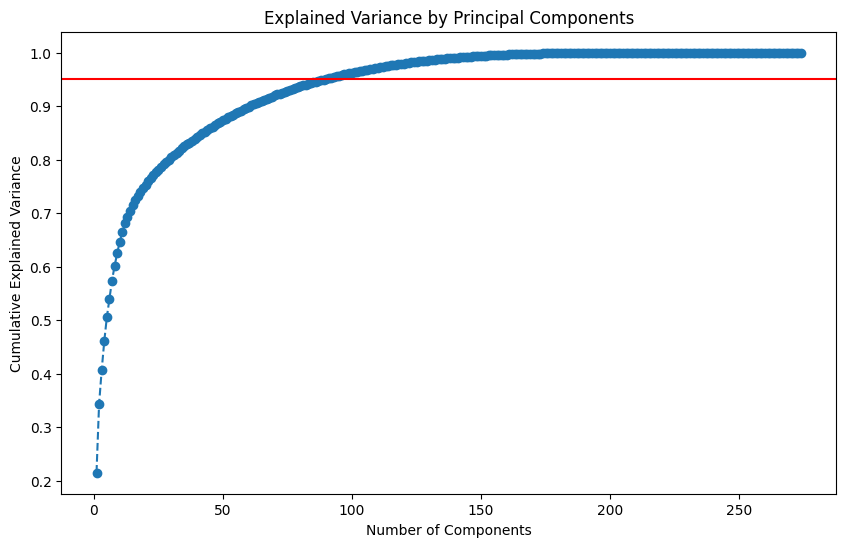

In [92]:
# Perform PCA on SDOH cols & plot explained variance ratio to determine optimal number of components
pca = PCA()
pca.fit(imputed_sdoh_cols)

# Plot the explained variance ratio
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.show()

In [93]:
# Find the number of components that explain 95% of the variance
n_components_95 = np.argmax(explained_variance_ratio >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

Number of components explaining 95% variance: 90


While 90 components seems like a lot, it is still significantly less than the original 309 SDOH features (274 after dropping some columns with many nulls).  Also, because we have 267,444 total observations, we are able to retain many features while still being well above the guideline of at least 10 observations: 1 feature.

In [24]:
# Perform PCA to scale 274 SDOH features down to 90 (explains 95% of variance)
pca = PCA(n_components=90).fit(imputed_sdoh_cols)
sdoh_cols_pca = pca.transform(imputed_sdoh_cols)

# Convert the result back to a df for easier manipulation
sdoh_cols_pca = pd.DataFrame(sdoh_cols_pca, columns=[f'SDOH_PC{i+1}' for i in range(90)]).reset_index(drop=True)
print("Shape of the dataset after PCA:", sdoh_cols_pca.shape)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Shape of the dataset after PCA: (200583, 90)


In [25]:
# Combine back to rest of features in training X dataset
X_train_2 = pd.concat([X_train_2_scaled[['All Teeth Lost', 'Annual Checkup', 'Any Disability', 'Arthritis', 'Binge Drinking', 'COPD', 'Cancer (except skin)', 'Cervical Cancer Screening', 'Cholesterol Screening', 'Chronic Kidney Disease', 'Cognitive Disability', 'Colorectal Cancer Screening', 'Core preventive services for older men', 'Core preventive services for older women', 'Coronary Heart Disease', 'Current Asthma', 'Current Smoking', 'Dental Visit', 'Depression', 'Diabetes', 'General Health', 'Health Insurance', 'Hearing Disability', 'High Blood Pressure', 'High Cholesterol', 'Independent Living Disability', 'Mammography', 'Mental Health', 'Mobility Disability', 'Obesity', 'Physical Health', 'Physical Inactivity', 'Self-care Disability', 'Sleep _7 hours', 'Stroke', 'Taking BP Medication', 'Vision Disability', 'race__API', 'race__Black', 'race__Latino', 'race__White', 'sex__Male', 'age_category',]], 
                       sdoh_cols_pca], axis=1)
X_train_2.shape

(200583, 133)

In [97]:
X_train_2.head()

,All Teeth Lost,Annual Checkup,Any Disability,Arthritis,Binge Drinking,COPD,Cancer (except skin),Cervical Cancer Screening,Cholesterol Screening,Chronic Kidney Disease,Cognitive Disability,Colorectal Cancer Screening,Core preventive services for older men,Core preventive services for older women,Coronary Heart Disease,Current Asthma,Current Smoking,Dental Visit,Depression,Diabetes,General Health,Health Insurance,Hearing Disability,High Blood Pressure,High Cholesterol,Independent Living Disability,Mammography,Mental Health,Mobility Disability,Obesity,Physical Health,Physical Inactivity,Self-care Disability,Sleep _7 hours,Stroke,Taking BP Medication,Vision Disability,race__API,race__Black,race__Latino,race__White,sex__Male,age_category,SDOH_PC1,SDOH_PC2,SDOH_PC3,SDOH_PC4,SDOH_PC5,SDOH_PC6,SDOH_PC7,SDOH_PC8,SDOH_PC9,SDOH_PC10,SDOH_PC11,SDOH_PC12,SDOH_PC13,SDOH_PC14,SDOH_PC15,SDOH_PC16,SDOH_PC17,SDOH_PC18,SDOH_PC19,SDOH_PC20,SDOH_PC21,SDOH_PC22,SDOH_PC23,SDOH_PC24,SDOH_PC25,SDOH_PC26,SDOH_PC27,SDOH_PC28,SDOH_PC29,SDOH_PC30,SDOH_PC31,SDOH_PC32,SDOH_PC33,SDOH_PC34,SDOH_PC35,SDOH_PC36,SDOH_PC37,SDOH_PC38,SDOH_PC39,SDOH_PC40,SDOH_PC41,SDOH_PC42,SDOH_PC43,SDOH_PC44,SDOH_PC45,SDOH_PC46,SDOH_PC47,SDOH_PC48,SDOH_PC49,SDOH_PC50,SDOH_PC51,SDOH_PC52,SDOH_PC53,SDOH_PC54,SDOH_PC55,SDOH_PC56,SDOH_PC57,SDOH_PC58,SDOH_PC59,SDOH_PC60,SDOH_PC61,SDOH_PC62,SDOH_PC63,SDOH_PC64,SDOH_PC65,SDOH_PC66,SDOH_PC67,SDOH_PC68,SDOH_PC69,SDOH_PC70,SDOH_PC71,SDOH_PC72,SDOH_PC73,SDOH_PC74,SDOH_PC75,SDOH_PC76,SDOH_PC77,SDOH_PC78,SDOH_PC79,SDOH_PC80,SDOH_PC81,SDOH_PC82,SDOH_PC83,SDOH_PC84,SDOH_PC85,SDOH_PC86,SDOH_PC87,SDOH_PC88,SDOH_PC89,SDOH_PC90
0,0.343237,0.077313,-0.156152,0.107189,-0.204332,0.555773,0.103157,-0.268437,-0.416528,-0.247438,-0.112257,-0.494759,-0.587547,-0.725070,0.026488,0.293390,0.565192,-0.237353,1.186254,-0.116666,-0.036519,-0.337320,-0.329006,-0.374773,-0.332906,-0.007811,-1.392002,0.286068,-0.095699,0.029192,-0.001646,0.403954,-0.351102,0.130806,-0.182838,0.550934,-0.350264,-0.321089,-0.506562,1.962151,-0.866430,-0.998132,-1.279557,-1.259757,-2.702519,-0.834934,4.219560,-1.480034,-2.107037,-1.575779,1.017246,0.674127,1.096199,1.311956,0.616024,-1.144399,0.826906,-2.871431,0.325821,1.258260,0.133944,-1.229346,-0.269065,-2.148563,-1.716841,-0.224101,0.880840,-0.966079,-1.700078,-1.114418,-0.733364,-0.790836,-0.345583,2.297448,-0.401963,0.859666,0.326217,-0.826674,-1.387471,0.310975,1.115490,0.272438,2.694707,-0.402244,-0.189522,1.766230,-0.919167,1.209945,-0.182890,-0.321200,0.267058,0.497514,-0.719737,0.101398,0.863907,0.433232,-0.642784,-0.168604,-0.346648,-0.124245,-0.043168,-0.402544,0.408253,0.099958,0.150860,-0.312911,-0.447307,0.808841,-0.204973,-0.192948,-0.163228,0.603728,0.068412,0.342410,0.414730,0.699573,0.138372,-0.587772,0.560472,-0.049314,-0.061711,-0.132158,-0.171981,0.217520,-0.858881,0.688659,-0.783329,0.136188,0.757231,-0.551469,-0.068374,0.447846,-0.622092
1,-1.531614,-1.476937,-1.577650,-2.542321,-2.862752,-2.096106,-1.944608,-2.083010,-1.806051,-2.174810,-0.488241,0.743833,0.566336,-0.290307,-2.276959,-0.385667,-2.898781,1.590759,0.722214,-1.845598,-1.658429,-0.282613,-1.593582,-2.570809,-2.390039,-1.224156,-0.360177,-0.112813,-1.968921,-1.479317,-1.376786,-1.983432,-1.607312,-1.157302,-2.127619,-3.894645,-1.338454,-0.321089,-0.506562,-0.509645,1.154162,-0.998132,-0.001444,13.062663,0.576856,-7.843543,1.409683,-5.106438,-5.059855,3.487607,2.204703,0.250725,1.432557,-1.255115,-4.529496,-2.229868,0.561094,-3.319592,-0.194119,-2.298382,0.611686,1.191341,0.492661,-0.087400,-1.937561,0.186652,-1.711581,-1.124995,-1.017329,1.883477,0.478779,0.958963,0.720472,2.144126,0.237624,1.166538,-1.559512,-1.758576,1.706255,-0.636690,0.096173,1.847903,1.051036,0.329384,0.056218,-0.329285,-0.014349,0.691737,-0.185419,0.569351,-0.917897,-0.421198,-0.467514,-0.571368,-0.251124,0.659779,0.524491,0.631473,-1.771840,1.313416,1.135314,0.687862,0.345555,0.276360,-0.351044,1.237562,0.329406,-0.813523,-0.354135,-0.309069,0.964109,-0.274410,-0.577476

#### Apply fitted transformers (KNNImputer, PCA & Scaling) to test features

In [26]:
# Apply fitted scaler first 
X_test_scaled_raw = scaler_2.transform(X_test_2_raw)
# Convert the imputed data back to a df for ease of working with further
X_test_scaled = pd.DataFrame(X_test_scaled_raw, columns=X_test_2_raw.columns)
# Check dimensions
X_test_scaled.shape

(66861, 317)

In [27]:
# Then, separate out SDOH cols from all others for KNNImputation & PCA 
test_SDOH_cols = X_test_scaled[[col for col in X_test_scaled.columns if col.startswith('ACS_')]]
# Then, apply fitted KNN Imputer
SDOH_cols_imputed_raw = imputer.transform(test_SDOH_cols)
# Convert the imputed data back to a df for ease of working with further
SDOH_cols_imputed = pd.DataFrame(SDOH_cols_imputed_raw, columns=test_SDOH_cols.columns)
# Check dimensions
SDOH_cols_imputed.shape

(66861, 274)

In [28]:
# Finally, apply fitted PCA
SDOH_cols_pca = pca.transform(SDOH_cols_imputed)
# Convert the result back to a df for easier manipulation
SDOH_cols_pca = pd.DataFrame(SDOH_cols_pca, columns=[f'SDOH_PC{i+1}' for i in range(90)]).reset_index(drop=True)
# Check dimensions
SDOH_cols_pca.shape

(66861, 90)

In [29]:
# Combine PCA features back to rest of features in test X dataset & check dimensions
X_test_2 = pd.concat([X_test_scaled[['All Teeth Lost', 'Annual Checkup', 'Any Disability', 'Arthritis', 'Binge Drinking', 'COPD', 'Cancer (except skin)', 'Cervical Cancer Screening', 'Cholesterol Screening', 'Chronic Kidney Disease', 'Cognitive Disability', 'Colorectal Cancer Screening', 'Core preventive services for older men', 'Core preventive services for older women', 'Coronary Heart Disease', 'Current Asthma', 'Current Smoking', 'Dental Visit', 'Depression', 'Diabetes', 'General Health', 'Health Insurance', 'Hearing Disability', 'High Blood Pressure', 'High Cholesterol', 'Independent Living Disability', 'Mammography', 'Mental Health', 'Mobility Disability', 'Obesity', 'Physical Health', 'Physical Inactivity', 'Self-care Disability', 'Sleep _7 hours', 'Stroke', 'Taking BP Medication', 'Vision Disability', 'race__API', 'race__Black', 'race__Latino', 'race__White', 'sex__Male', 'age_category',]], 
                       SDOH_cols_pca], axis=1)
X_test_2.shape

(66861, 133)

## Modeling

In [121]:
# Define models and hyperparameters to look through via GridSearch
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42),
    'SVR': SVR()
}

params = {
    'LinearRegression': {},
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]},
    'XGBRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [10, 20, 30]},
    'LGBMRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [10, 20, 30]},
    'SVR': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}
}

In [111]:
# I will be using RMSE as the metric by which to evaluate the best hyperparameters for each model,
    # so defining the RMSE metric function here
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create custom scorer
rmse_score = make_scorer(rmse_scorer, greater_is_better=False)

### Modeling Approach #1: Limited SDOH Columns

#### Identifying Optimal Model for Approach #1

In [117]:
# Loop through models to identify optimal hyperparameters for each
best_models = {}
best_params = {}
for model_name in models:
    print(f"Training {model_name}...")
    model = models[model_name]
    param_grid = params[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmse_score)
    grid_search.fit(X_train_1, y_train_1)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_

Training LinearRegression...
Training Ridge...
Training Lasso...
Training ElasticNet...
Training XGBRegressor...
Training LGBMRegressor...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000097
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [W

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160376, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000097
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead o

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160376, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGB

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Fou

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000097
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 160375, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGB

In [136]:
# Test the best models and print RMSE for train & test set
results = {}
for model_name, model in best_models.items():
    # Train RMSE
    y_train_pred = model.predict(X_train_1)
    train_rmse = np.sqrt(mean_squared_error(y_train_1, y_train_pred))
    
    # Test RMSE
    y_test_pred = model.predict(X_test_1)
    test_rmse = np.sqrt(mean_squared_error(y_test_1, y_test_pred))
    
    results[model_name] = (train_rmse, test_rmse)
    print(f"{model_name} Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# Print hyperparams for above best models
print("\nBest hyperparameters for each model:")
for model_name, params in best_params.items():
    print(f"{model_name}: {params}")

LinearRegression Train RMSE: 0.00012377678604693363, Test RMSE: 0.00012376816313712153
Ridge Train RMSE: 0.00012377681223005936, Test RMSE: 0.00012376812451090054
Lasso Train RMSE: 0.00017784429793733949, Test RMSE: 0.0001782457363475835
ElasticNet Train RMSE: 0.00017784429793733949, Test RMSE: 0.0001782457363475835
XGBRegressor Train RMSE: 4.801690050800896e-05, Test RMSE: 4.840805181140467e-05
LGBMRegressor Train RMSE: 3.114510217601016e-05, Test RMSE: 3.5869828114130456e-05
SVR Train RMSE: 0.0011862408567815013, Test RMSE: 0.001186150310426834

Best hyperparameters for each model:
LinearRegression: {}
Ridge: {'alpha': 10.0}
Lasso: {'alpha': 0.1}
ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.1}
XGBRegressor: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
SVR: {'C': 0.1, 'epsilon': 1}


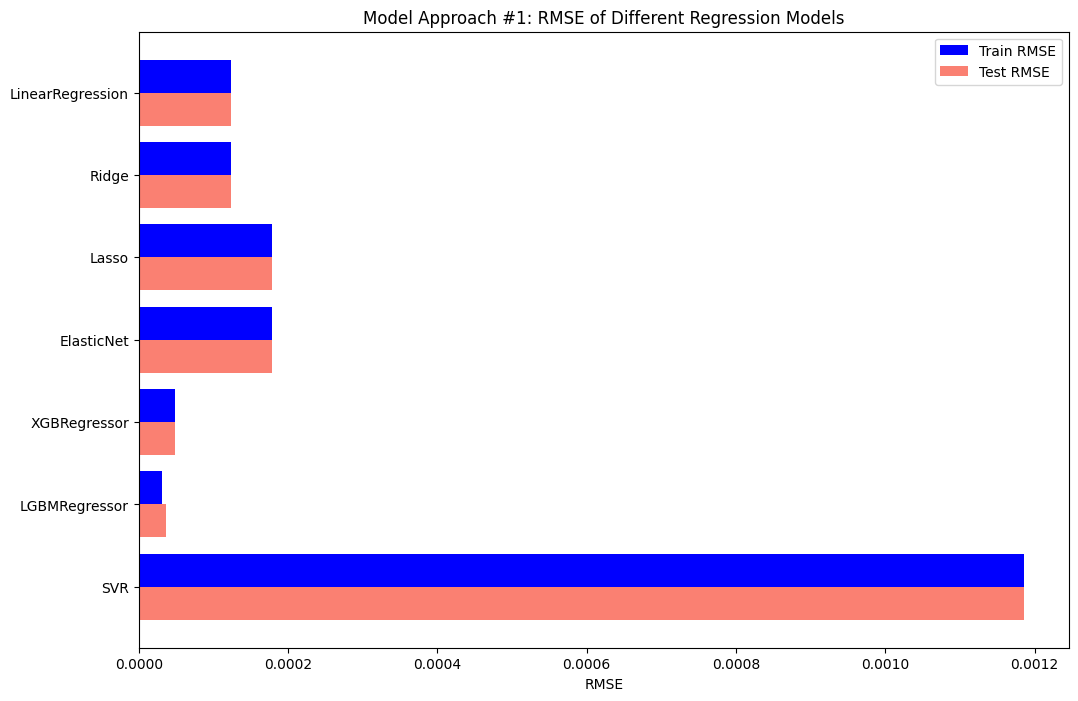

In [137]:
# Extracting model names and RMSE values
model_names = list(results.keys())
train_rmse_values = [results[name][0] for name in model_names]
test_rmse_values = [results[name][1] for name in model_names]

# Plotting the clustered horizontal bar graph
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(model_names))

# Creating the bars
bar1 = ax.barh(index - bar_width/2, train_rmse_values, bar_width, label='Train RMSE', color='blue')
bar2 = ax.barh(index + bar_width/2, test_rmse_values, bar_width, label='Test RMSE', color='salmon')

# Adding labels and title
ax.set_xlabel('RMSE')
ax.set_title('Model Approach #1: RMSE of Different Regression Models')
ax.set_yticks(index)
ax.set_yticklabels(model_names)  
ax.invert_yaxis()
ax.legend()

# Display the plot
plt.show()

#### Approach #1 Final Model

In [30]:
# Train LightGBM Regressor with optimal hyperparameters
lgb_model = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=200, random_state=42)
lgb_model.fit(X_train_1, y_train_1)

# Predict on the test set and calculate RMSE
y_test_pred = lgb_model.predict(X_test_1)
test_rmse = np.sqrt(mean_squared_error(y_test_1, y_test_pred))
print(f"LGBMRegressor Test RMSE: {test_rmse}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13072
[LightGBM] [Info] Number of data points in the train set: 200469, number of used features: 58
[LightGBM] [Info] Start training from score 0.000096
LGBMRegressor Test RMSE: 3.5869828114130456e-05


In [52]:
# Calculate adjusted R2 for LightGBM Model for Approach #1 
r2 = r2_score(y_test_1['TARGET_mortality_rate'], y_test_pred)

# Get the number of observations and predictors
n = len(y_test_1)
p = X_test_1.shape[1]

# Calculate Adjusted R^2
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
print(f"Adjusted R^2: {adjusted_r2}")

Adjusted R^2: 0.9594680283589666


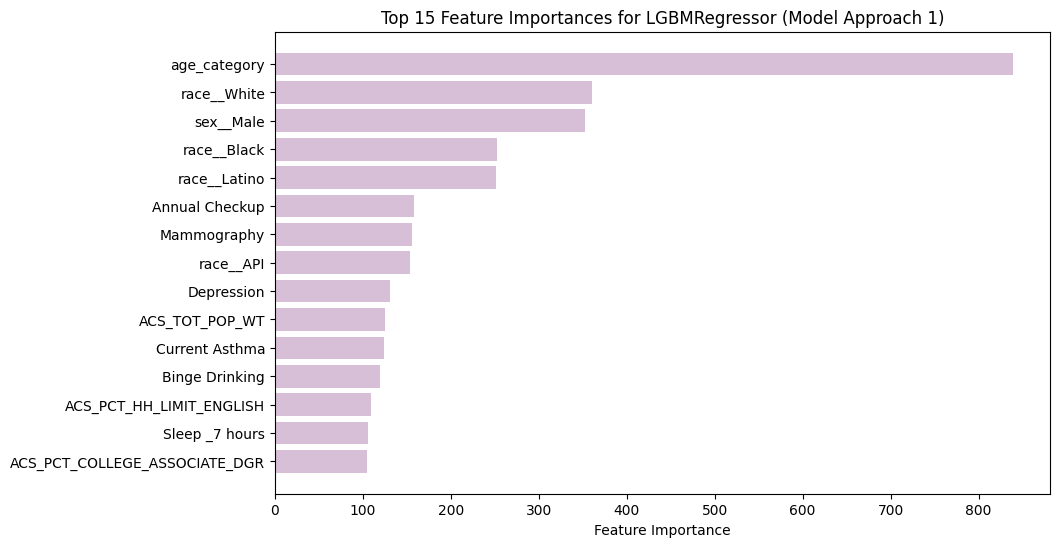

In [33]:
# Get & visualize feature importance for LightGBM model
feature_importances = lgb_model.feature_importances_

# Visualize feature importances
feature_names = X_train_1.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)  # Limit to top 15 features to be able to visualize

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='thistle')
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for LGBMRegressor (Model Approach 1)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

### Modeling Approach #2: PCA on SDOH Columns

#### Identifying Optimal Model for Approach #2

In [122]:
# Model 2: Evaluate models using GridSearchCV and print best hyperparameters
best_models_2 = {}
best_params_2 = {}
for model_name in models:
    print(f"Training {model_name}...")
    model = models[model_name]
    param_grid = params[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmse_score)
    grid_search.fit(X_train_2, y_train_2)
    best_models_2[model_name] = grid_search.best_estimator_
    best_params_2[model_name] = grid_search.best_params_

Training LinearRegression...
Training Ridge...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160467, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160466, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160467, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160466, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Light

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160467, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160466, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160467, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 160466, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead

In [138]:
# Test the best models and evaluate performance
results_2 = {}
for model_name, model in best_models_2.items():
    # Train RMSE
    y_train_pred = model.predict(X_train_2)
    train_rmse = np.sqrt(mean_squared_error(y_train_2, y_train_pred))
    
    # Test RMSE
    y_test_pred = model.predict(X_test_2)
    test_rmse = np.sqrt(mean_squared_error(y_test_2, y_test_pred))
    
    results_2[model_name] = (train_rmse, test_rmse)
    print(f"{model_name} Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# Print hyperparams for above best models
print("\nBest hyperparameters for each model:")
for model_name, params in best_params_2.items():
    print(f"{model_name}: {params}")

LinearRegression Train RMSE: 0.0001236869572664135, Test RMSE: 0.0001238387664351667
Ridge Train RMSE: 0.00012368696149813146, Test RMSE: 0.00012383843083366866
Lasso Train RMSE: 0.00017786467996379202, Test RMSE: 0.00017831017819869922
ElasticNet Train RMSE: 0.00017786467996379202, Test RMSE: 0.00017831017819869922
XGBRegressor Train RMSE: 4.776848315751845e-05, Test RMSE: 4.906119169058956e-05
LGBMRegressor Train RMSE: 3.0024092564045237e-05, Test RMSE: 3.552314112863211e-05
SVR Train RMSE: 0.0011861764318958092, Test RMSE: 0.0011863205015235584

Best hyperparameters for each model:
LinearRegression: {}
Ridge: {'alpha': 10.0}
Lasso: {'alpha': 0.1}
ElasticNet: {'alpha': 0.1, 'l1_ratio': 0.1}
XGBRegressor: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
LGBMRegressor: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 200}
SVR: {'C': 0.1, 'epsilon': 1}


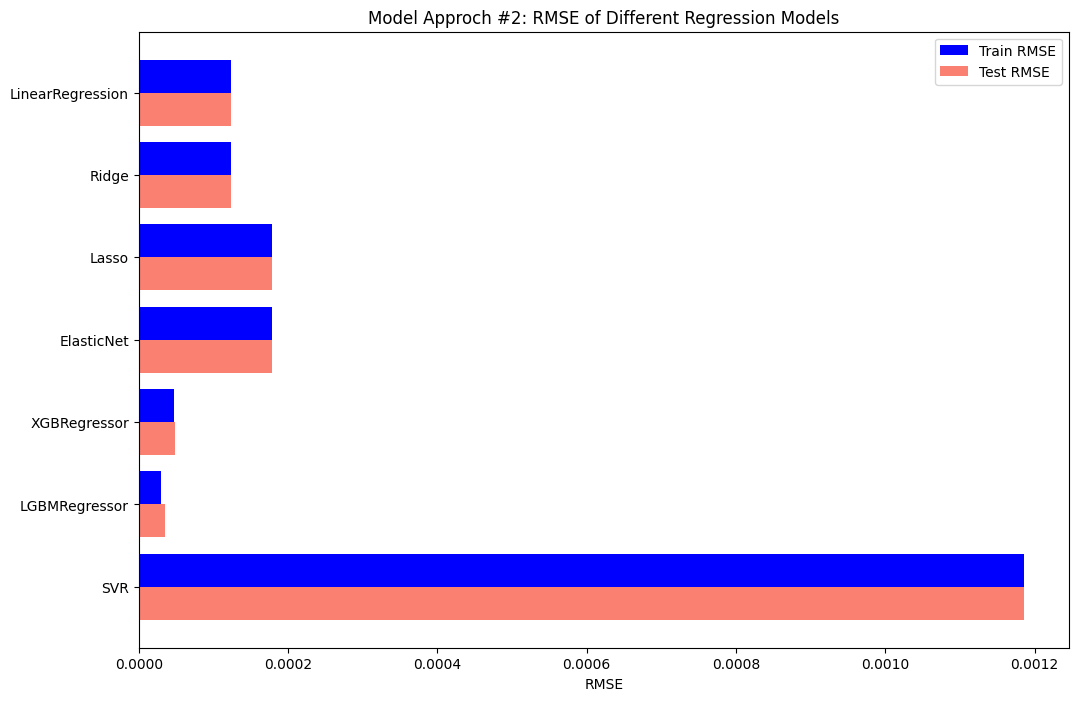

In [139]:
# Visualize Results (RMSE for each model)
# Extracting model names and RMSE values
model_names = list(results_2.keys())
train_rmse_values = [results_2[name][0] for name in model_names]
test_rmse_values = [results_2[name][1] for name in model_names]

# Plotting the clustered horizontal bar graph
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.4
index = np.arange(len(model_names))

# Creating the bars
bar1 = ax.barh(index - bar_width/2, train_rmse_values, bar_width, label='Train RMSE', color='blue')
bar2 = ax.barh(index + bar_width/2, test_rmse_values, bar_width, label='Test RMSE', color='salmon')

# Adding labels and title
ax.set_xlabel('RMSE')
ax.set_title('Model Approch #2: RMSE of Different Regression Models')
ax.set_yticks(index)
ax.set_yticklabels(model_names)  
ax.invert_yaxis()
ax.legend()

# Display the plot
plt.show()

#### Approach #2 Final Model

In [34]:
# Train LightGBM Regressor with optimal hyperparameters
lgb_model_2 = LGBMRegressor(learning_rate=0.1, max_depth=20, n_estimators=200, random_state=42)
lgb_model_2.fit(X_train_2, y_train_2)

# Predict on the test set #2 and calculate RMSE
y_test_pred_2 = lgb_model_2.predict(X_test_2)
test_rmse_2 = np.sqrt(mean_squared_error(y_test_2, y_test_pred_2))
print(f"LGBMRegressor Test RMSE: {test_rmse_2}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32420
[LightGBM] [Info] Number of data points in the train set: 200583, number of used features: 133
[LightGBM] [Info] Start training from score 0.000096
LGBMRegressor Test RMSE: 3.531150730734809e-05


In [49]:
# Calculate adjusted R2 for LightGBM Model 2 to see if better than for Model 1
r2 = r2_score(y_test_2['TARGET_mortality_rate'], y_test_pred_2)

# Get the number of observations and predictors
n = len(y_test_2)
p = X_test_2.shape[1]

# Calculate Adjusted R^2
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
print(f"Adjusted R^2: {adjusted_r2}")

Adjusted R^2: 0.9607042936012695


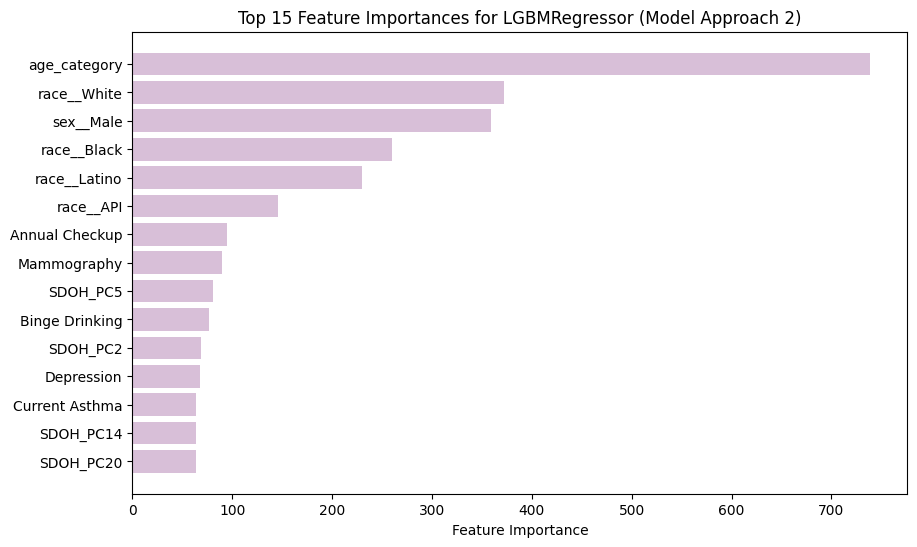

In [35]:
# Get & visualize feature importance for model
feature_importances = lgb_model_2.feature_importances_

# Visualize feature importances
feature_names = X_train_2.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)  # Limit to top 15 features to be able to visualize

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='thistle')
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances for LGBMRegressor (Model Approach 2)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

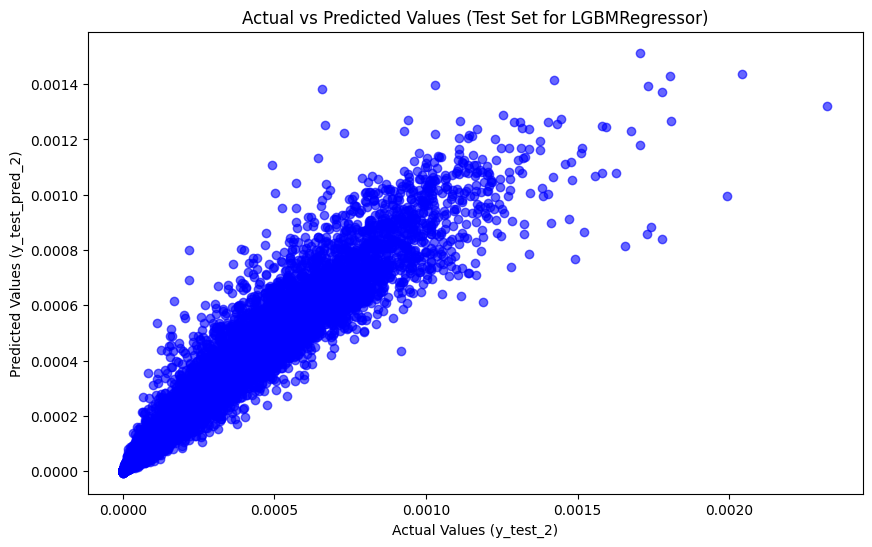

In [37]:
# Compare y_pred vs. y_true for lgb_model_2
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_test_pred_2, alpha=0.6, color='b')  # Scatter plot
#plt.plot([min(y_test_2), max(y_test_2)], [min(y_test_2), max(y_test_2)], color='red', linewidth=2)  # Line of perfect prediction
plt.xlabel('Actual Values (y_test_2)')
plt.ylabel('Predicted Values (y_test_pred_2)')
plt.title('Actual vs Predicted Values (Test Set for LGBMRegressor)')
plt.show()

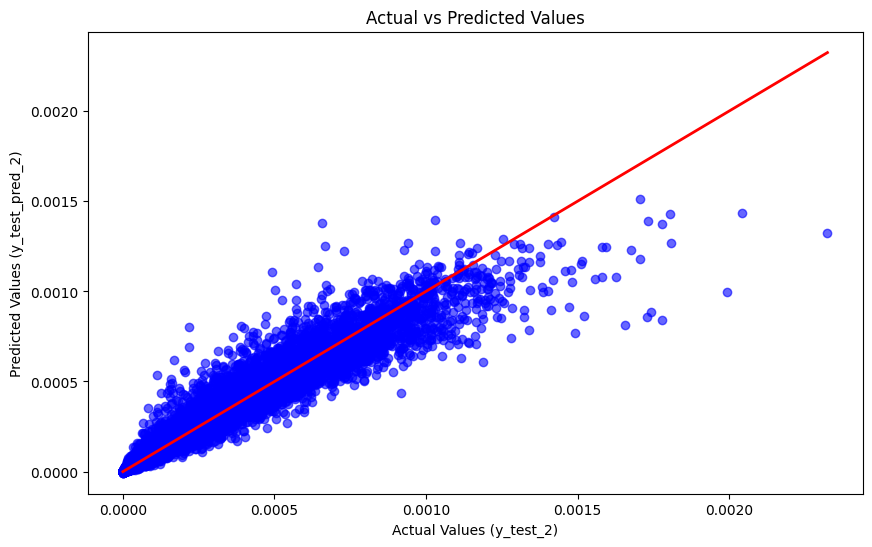

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_2, y_test_pred_2, alpha=0.6, color='b')

# Plot the line of perfect prediction
plt.plot([min(y_test_2['TARGET_mortality_rate']), max(y_test_2['TARGET_mortality_rate'])], 
         [min(y_test_2['TARGET_mortality_rate']), max(y_test_2['TARGET_mortality_rate'])], 
         color='red', linewidth=2, label='Perfect Prediction') 

# Labeling the plot
plt.xlabel('Actual Values (y_test_2)')
plt.ylabel('Predicted Values (y_test_pred_2)')
plt.title('Actual vs Predicted Values')
plt.show()

In [47]:
# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(y_test_2['TARGET_mortality_rate'], y_test_pred_2)[0,1]
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.9802316472787662


### Final Model (LGBMRegressor): SHAP Values
The final model we will be using is the LGBMRegressor result from Approach #2, as it had the lowest test RMSE. For increased model explainability beyond the global feature importance graph, we will also delve into SHAP values.

In [146]:
# Create the SHAP explainer & values for the test set
explainer = shap.TreeExplainer(lgb_model_2)
shap_values = explainer.shap_values(X_test_2)

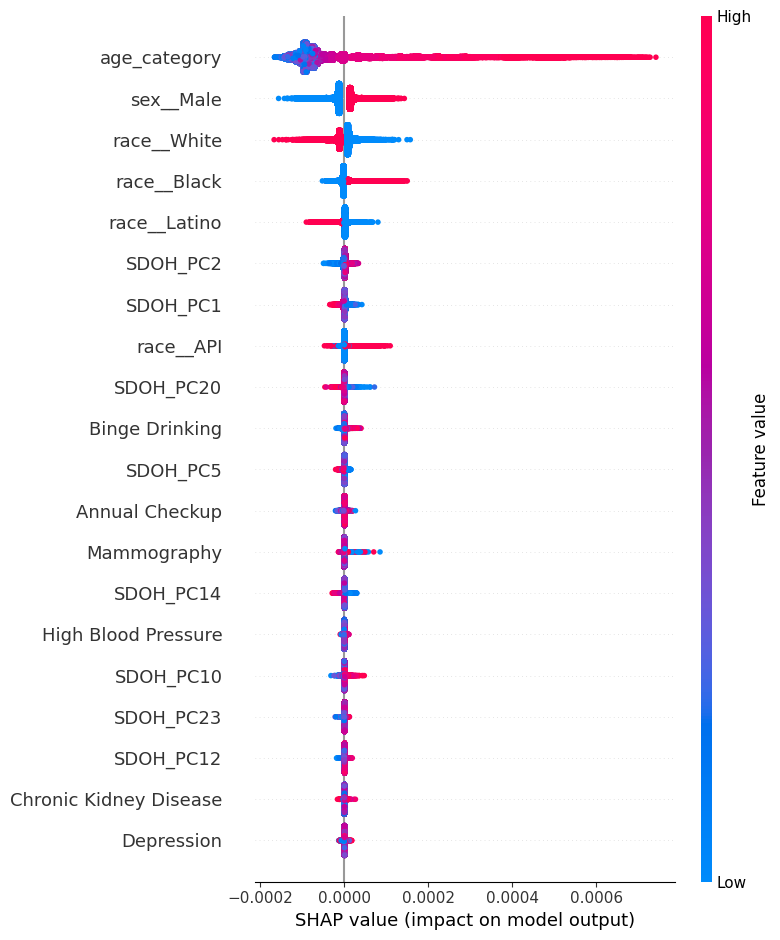

In [147]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_2)

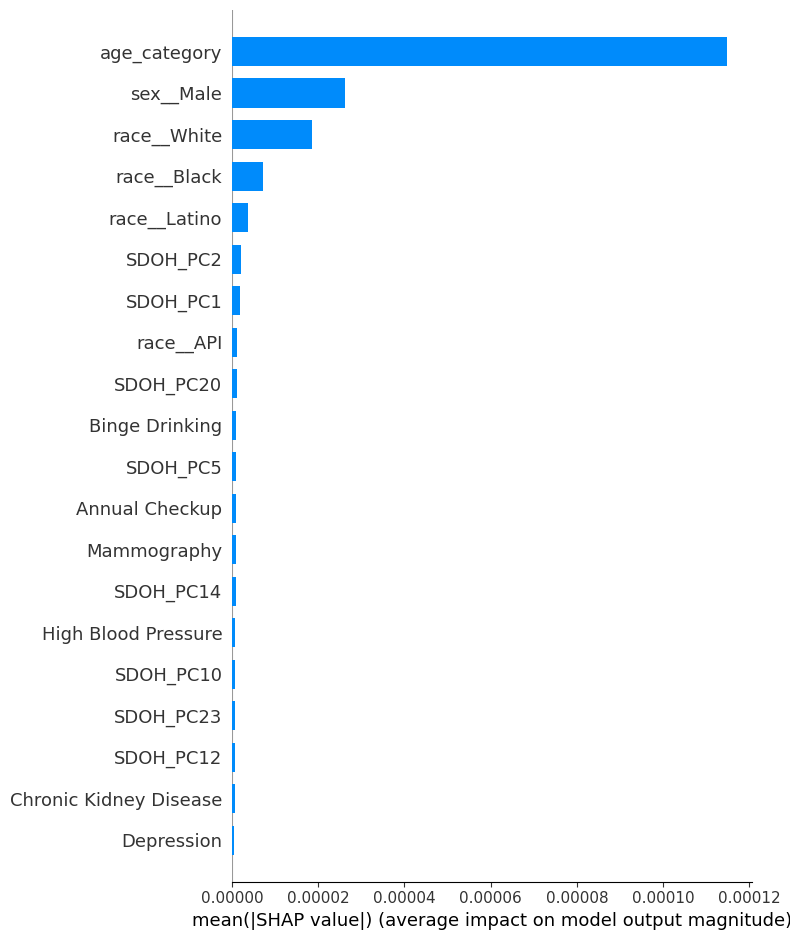

In [148]:
shap.summary_plot(shap_values, X_test_2, plot_type="bar")

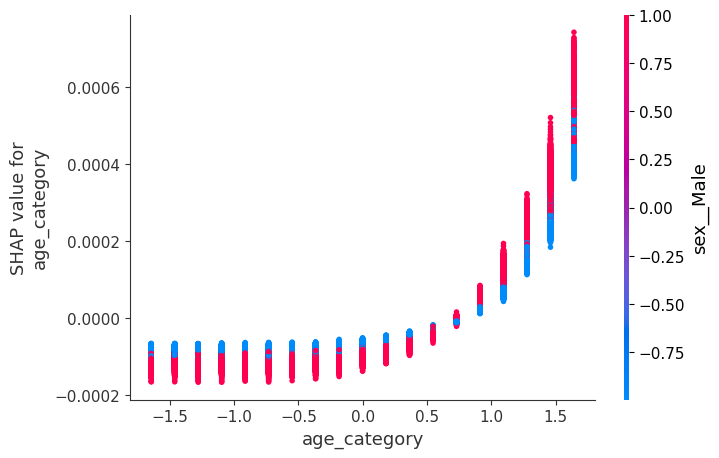

In [149]:
# Dependence plot for a specific feature (in this case, the most important one)
most_important_feature = X_test_2.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X_test_2)

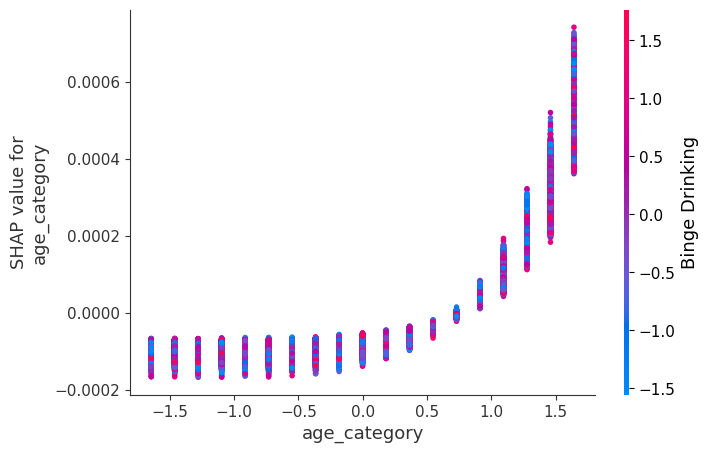

In [153]:
# Try another dependence plot
shap.dependence_plot('age_category', shap_values, X_test_2, interaction_index='Binge Drinking')

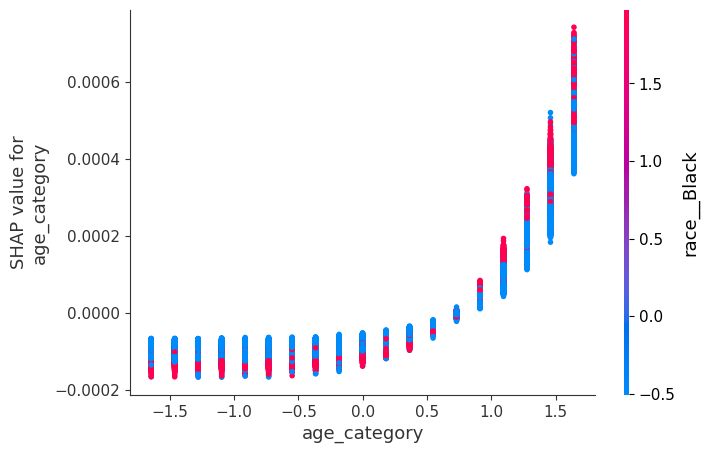

In [158]:
# Try another dependence plot
shap.dependence_plot('age_category', shap_values, X_test_2, interaction_index='race__Black')